### Predicting **Bee** Vs **Wasp**

#### DL project by Ayushman Rayaguru

### Wasps and honey bees are both members of the Hymenoptera order of insects. However, their physical bodies are different. ... Honey bees are hairy, while wasps usually have smooth and shiny skin. Wasps are narrow-waisted, have four wings and may be brightly colored, with black and yellow patterns.

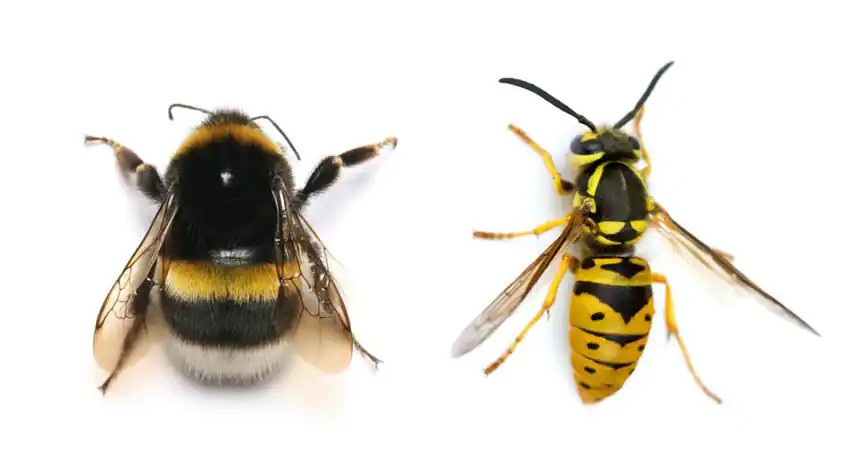

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.spines as spines
import seaborn as sns
import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.losses as losses
import tensorflow.keras.callbacks as callbacks

In [ ]:
tf.config.experimental.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
DATASET_PATH = "../input/bee-vs-wasp/kaggle_bee_vs_wasp"

label_csv = os.path.join(DATASET_PATH, 'labels.csv')

# Data exploration

In [ ]:
label_df = pd.read_csv(label_csv)
label_df.head(10)

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1\10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1\10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1\10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1\1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1\10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee
5,6,bee1\10130729734_f68738333e_w.jpg,1,0,0,0,1,0,0,bee
6,7,bee1\10166485783_9cd6706c72_n.jpg,1,0,0,0,1,0,0,bee
7,8,bee1\10179824_84803290ac_m.jpg,1,0,0,0,1,0,0,bee
8,9,bee1\10197482094_0176d1bacb_n.jpg,1,0,0,0,1,0,0,bee
9,10,bee1\10242298546_aac12f5223_n.jpg,1,0,0,0,1,0,0,bee


**labels.csv** columns description :

- id - ordinal - unique index
- path - string - relative path to the photo, including extension
- is_bee - nominal - 1 if there is a bee in the photo
- is_wasp - nominal - 1 if there is a wasp in the photo
- is_otherinsect - nominal - 1 if there is other insect prominently in the centre of the photo, but it is not a wasp and not a bee. It might be a fly, but there are other things there too, like beetles
- is_other - random photos not containing any insects
- photo_quality - 1 for photos where I have very high confidence that it is bee, wasp, or other. 0 for photos of generally low quality or where I am not very confident that it is - what it says it is. You can use this to initially reduce the size of the training set
- is_validation - you can use this for your training validation, or you can combine these with the training data and split your training/validation differently
- is_final_validation - do NOT use these photos for training - use them to compute your final score. This will enable comparing results by different kagglers. Optionally, if you want to deploy an app to actually serve the model, you can then use these for final training too.

Our dataset is well prepared since there is no missing value, let's move on

In [ ]:
print('Number of null values')
label_df.isnull().sum()

Number of null values


id                     0
path                   0
is_bee                 0
is_wasp                0
is_otherinsect         0
is_other               0
photo_quality          0
is_validation          0
is_final_validation    0
label                  0
dtype: int64

Before get some intuition about data, let's generate new column which can help us to quickly know that image is train/validation/test
From the description we know that validation image is declared in **is_validation** and test belongs to **is_final_validation**

In [ ]:
def set_train_type(row):
    if row['is_validation'] == 0 and row['is_final_validation'] == 0:
        return 'train'
    if row['is_validation'] == 1:
        return 'validation'
    return 'test'

label_df['type'] = label_df.apply(set_train_type, axis=1)
print('Number values of each type')
label_df['type'].value_counts()

Number values of each type


train         7939
test          1763
validation    1719
Name: type, dtype: int64

Look like our dataset is separeated into these parts:
- train: 80%
- validation: 10%
- test: 10%

Now let's get intuition with by plotting some useful information

# Visualization

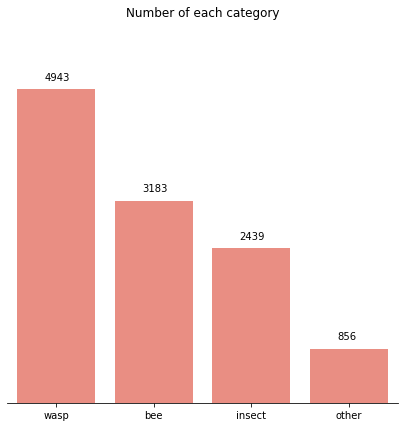

In [ ]:
insect_cat_counts = label_df["label"].value_counts()

plt.figure(figsize=(7,7))
g = sns.barplot(x=insect_cat_counts.index, y =insect_cat_counts, color='salmon')
g.set(title='Number of each category', ylim=[0,6000], yticks=[], ylabel='')
sns.despine(top=True, right=True, left=True, bottom=False)

for i in range(4):
    plt.text(x=i-0.12, y=insect_cat_counts[i] + 150, s=insect_cat_counts[i])
plt.show()

Our above chart indicate that **Wasp** has the most number of image in our dataset, then **Bee**, **Other insect**, and the last is **Other**. Notice that these are the total number of each category include both train and validation and image.

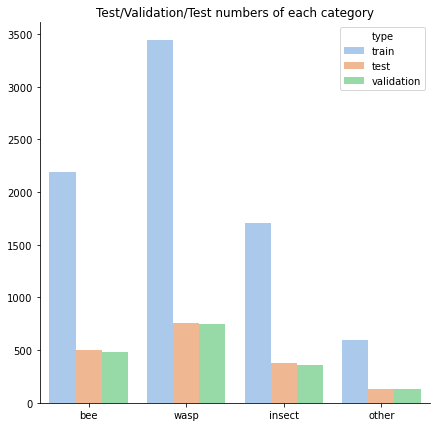

In [ ]:
plt.figure(figsize=(7,7))
g = sns.countplot(x='label', hue='type', data=label_df, palette="pastel")
g.set(xlabel='', ylabel='', title="Test/Validation/Test numbers of each category")
sns.despine()
plt.show()

As we saw above that train/validation/test data are separated into 80/10/10, our data for each category also are separedted into same portion. Thank to our author who created also well cleaned our dataset

Finally, we will see the quality of images that are collected

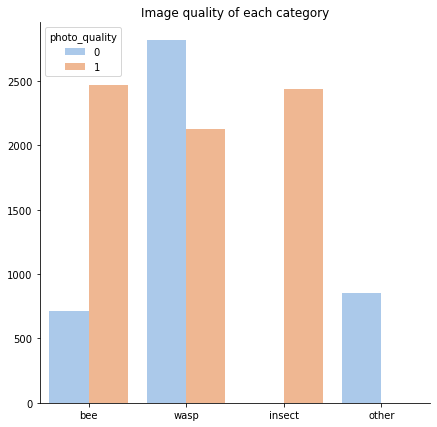

In [ ]:
plt.figure(figsize=(7,7))
g = sns.countplot(x='label', hue='photo_quality', data=label_df, palette="pastel")
g.set(xlabel='', ylabel='', title="Image quality of each category")
sns.despine()
plt.show()

We can notice these things:
- Wasp has the most number of images but it also have the most bad quality images, with bad quality is over 2500 and good quality is about 2000. 
- Bee was collected with most of good images with over 2400 images, and about 600-700 bad quality images.
- Other insects only contain good quality images.
- Other animals only contain bad quality images.

In [ ]:
def display_img(row, pos):
    #Because path use back slash which is 
    #not compatible for both windows nor linux environment
    #we will first replace back slash with forward slash
    fn = row['path'].replace('\\', os.sep)
    fn = os.path.join(DATASET_PATH, fn)
    #Read image from path
    img = cv2.imread(fn)
    #Resize all images with the same size
    img = cv2.resize(img, (128, 128))
    #Set RGB color for image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Display image, and set title
    plt.subplot(4, 5, pos)
    plt.imshow(img)
    plt.title(row['label'])
    #Remove ticks
    plt.xticks([])
    plt.yticks([])

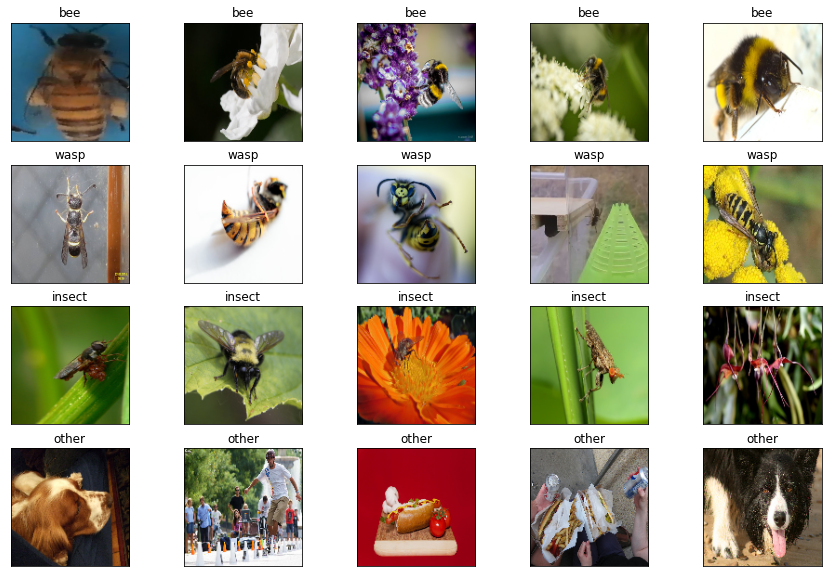

In [ ]:
bee = label_df[label_df["label"] == 'bee'].sample(5, random_state=42)
wasp = label_df[label_df["label"] == 'wasp'].sample(5, random_state=42)
insect = label_df[label_df["label"] == 'insect'].sample(5, random_state=42)
other = label_df[label_df["label"] == 'other'].sample(5, random_state=42)

plt.figure(figsize=(15,10))
pos = 1
# Display bee
for idx, row in bee.iterrows():
    display_img(row, pos)
    pos += 1
# Display wasp    
for idx, row in wasp.iterrows():
    display_img(row, pos)
    pos += 1
# Display other insects
for idx, row in insect.iterrows():
    display_img(row, pos)
    pos += 1
# Display others
for idx, row in other.iterrows():
    display_img(row, pos)
    pos += 1
    
plt.show()

We can see that not only bee and wasp are hard for us to classify but also other insects are hard too, since some of them just take a small portion in image. With others we can clearly see that they absolutely different to bee, wasp, and other insects, hope that with other, we can get the best confidence in prediction.

# Data preparation

Before create training data, we should replace backward slash with current environment default slash as we did while displaying images above

In [ ]:
label_df['path'] = label_df['path'].str.replace('\\', os.sep)
label_df['path'].head()

0    bee1/10007154554_026417cfd0_n.jpg
1    bee1/10024864894_6dc54d4b34_n.jpg
2    bee1/10092043833_7306dfd1f0_n.jpg
3     bee1/1011948979_fc3637e779_w.jpg
4    bee1/10128235063_dca17db76c_n.jpg
Name: path, dtype: object

Great, let's get train/validation/test data separately

In [ ]:
train_df = label_df[label_df['type'] == 'train']
valid_df = label_df[label_df['type'] == 'validation']
test_df = label_df[label_df['type'] == 'test']

Let's create datagen, remember to scale all images into same shape since they don't have the same image size, also we have bad quality images, let's try 256 pixel for image size

In [ ]:
TARGET_SIZE = (256, 256)
SEED = 42

In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train_datagen = datagen.flow_from_dataframe(train_df, 
                                            directory=DATASET_PATH, 
                                            x_col='path', 
                                            y_col='label',
                                            target_size=TARGET_SIZE,
                                            seed=42
                                           ) 

valid_datagen = datagen.flow_from_dataframe(valid_df,
                                            directory=DATASET_PATH, 
                                            x_col='path', 
                                            y_col='label',
                                            target_size=TARGET_SIZE,
                                            seed=42
                                           ) 

test_datagen = datagen.flow_from_dataframe(test_df, 
                                           directory=DATASET_PATH, 
                                           x_col='path', 
                                           y_col='label',
                                           target_size=TARGET_SIZE,
                                           seed=42
                                           ) 

Found 7939 validated image filenames belonging to 4 classes.
Found 1719 validated image filenames belonging to 4 classes.
Found 1763 validated image filenames belonging to 4 classes.


In [ ]:
n_class = len(label_df['label'].unique())

# Train and evaluate

## From scratch

We will use relularize, dropout, batch norm, and pooling for our scratch model. 
Note that we will not apply data augmentation.

In [ ]:
from tensorflow.keras.initializers import RandomNormal, Constant

model = models.Sequential([
    # Block 1
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001), input_shape=(256,256,3)),
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.BatchNormalization(momentum=0.6, 
                              epsilon=0.005, 
                              beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                              gamma_initializer=Constant(value=0.9)
                             ),    
    layers.Activation('relu'),
    layers.MaxPooling2D(3),
    layers.Dropout(0.3),
    
    # Block 2
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.Conv2D(128, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.BatchNormalization(momentum=0.6, 
                              epsilon=0.005, 
                              beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                              gamma_initializer=Constant(value=0.9)
                             ),
    layers.Activation('relu'),
    layers.MaxPooling2D(3),
    layers.Dropout(0.3),
    
    # Block 3
    layers.Conv2D(256, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.Conv2D(256, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.BatchNormalization(momentum=0.6, 
                              epsilon=0.005, 
                              beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                              gamma_initializer=Constant(value=0.9)
                             ), 
    layers.Activation('relu'),
    layers.MaxPooling2D(3),
    layers.Dropout(0.3),
    
    # Block 4
    layers.Conv2D(512, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.Conv2D(512, 3, padding='same', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.BatchNormalization(momentum=0.6, 
                              epsilon=0.005, 
                              beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                              gamma_initializer=Constant(value=0.9)
                             ), 
    layers.Activation('relu'),
    layers.MaxPooling2D(3),
    layers.Dropout(0.3),

    # Block 5
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.L2(0.001)),
    layers.Dense(n_class, activation='softmax')
])

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.BinaryCrossentropy(),
              metrics=['accuracy']
             )

In [ ]:
early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(train_datagen, 
          validation_data=valid_datagen, 
          callbacks=[early_stopping],
          batch_size=32,
          epochs=50,
         )

Epoch 1/50
249/249 [==============================] - 84s 337ms/step - loss: 2.4430 - accuracy: 0.6236 - val_loss: 2.5250 - val_accuracy: 0.5428
Epoch 2/50
249/249 [==============================] - 80s 321ms/step - loss: 2.0912 - accuracy: 0.7195 - val_loss: 2.1762 - val_accuracy: 0.5782
Epoch 3/50
249/249 [==============================] - 80s 320ms/step - loss: 1.8108 - accuracy: 0.7631 - val_loss: 1.7371 - val_accuracy: 0.7289
Epoch 4/50
249/249 [==============================] - 80s 322ms/step - loss: 1.5732 - accuracy: 0.7893 - val_loss: 1.5061 - val_accuracy: 0.7696
Epoch 5/50
249/249 [==============================] - 80s 319ms/step - loss: 1.3852 - accuracy: 0.8011 - val_loss: 1.2863 - val_accuracy: 0.8202
Epoch 6/50
249/249 [==============================] - 81s 324ms/step - loss: 1.2170 - accuracy: 0.8176 - val_loss: 1.1833 - val_accuracy: 0.7871
Epoch 7/50
249/249 [==============================] - 80s 321ms/step - loss: 1.0821 - accuracy: 0.8326 - val_loss: 1.0236 - val_ac

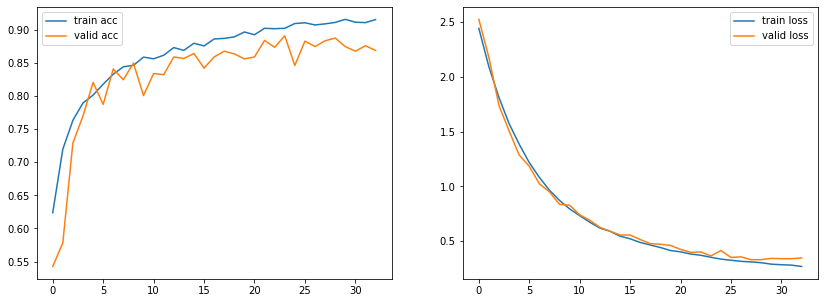

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='train acc')
plt.plot(val_acc, label='valid acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='train loss')
plt.plot(val_loss, label='valid loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_datagen, verbose=2)
print("Test accuracy:", test_acc)

56/56 - 8s - loss: 0.3250 - accuracy: 0.8905
Test accuracy: 0.8905274868011475


We will use resnet50 as pretrain model to apply transfer learning

## Transfer learning

In [ ]:
resnet50 = keras.applications.ResNet50(include_top=False, input_shape=(256, 256, 3))

In [ ]:
from tensorflow.keras.initializers import RandomNormal, Constant

model = models.Sequential([
    resnet50,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(n_class, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss=losses.BinaryCrossentropy(),
              metrics=['accuracy']
             )
early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_datagen, 
          validation_data=valid_datagen, 
          callbacks=[early_stopping],
          batch_size=32,
          epochs=50,
         )

Epoch 1/50
249/249 [==============================] - 69s 277ms/step - loss: 0.1352 - accuracy: 0.8952 - val_loss: 0.5686 - val_accuracy: 0.3642
Epoch 2/50
249/249 [==============================] - 67s 270ms/step - loss: 0.0436 - accuracy: 0.9699 - val_loss: 0.6140 - val_accuracy: 0.3921
Epoch 3/50
249/249 [==============================] - 68s 272ms/step - loss: 0.0338 - accuracy: 0.9781 - val_loss: 0.5310 - val_accuracy: 0.6894
Epoch 4/50
249/249 [==============================] - 67s 271ms/step - loss: 0.0139 - accuracy: 0.9921 - val_loss: 0.1426 - val_accuracy: 0.9116
Epoch 5/50
249/249 [==============================] - 67s 269ms/step - loss: 0.0110 - accuracy: 0.9928 - val_loss: 0.1369 - val_accuracy: 0.9348
Epoch 6/50
249/249 [==============================] - 67s 268ms/step - loss: 0.0237 - accuracy: 0.9859 - val_loss: 0.2262 - val_accuracy: 0.8871
Epoch 7/50
249/249 [==============================] - 67s 268ms/step - loss: 0.0177 - accuracy: 0.9883 - val_loss: 0.2536 - val_ac

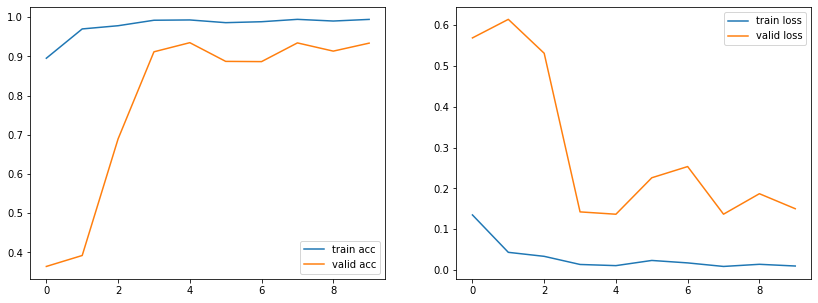

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='train acc')
plt.plot(val_acc, label='valid acc')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='train loss')
plt.plot(val_loss, label='valid loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_datagen, verbose=2)
print("Test accuracy:", test_acc)

56/56 - 9s - loss: 0.1265 - accuracy: 0.9421
Test accuracy: 0.9421440958976746


We got accuracy 94% by using transfer learning with resnet50, while our sratch model get 89%. Also we only train 10 epochs on transfer learning model, since sratch model take 33 epochs, that means transfer learning get higher accuracy with less epochs.